# Using Graph Theory to Model Chemical Reaction Networks

*By Dr. Tyler Biggs*

---

## Consider a Chemical Reaction Network

---



## In Python with NetworkX

---

To model a network of chemical reactions we need a multi-e

In [1]:
import networkx as nx
import numpy as np
import scipy
import tqdm
import matplotlib.pyplot as plt
import itertools
import collections
from scipy.special import factorial
%matplotlib inline

### Self-Equilibriating Reactions

Given by the equations:

$$ \bar{X} + Y \xrightarrow{c_1} 2Y $$

$$ 2Y \xrightarrow{c_2} Z $$

Where $\bar{X}$ is held constant, effectively representing an inexhaustible supply.

Where $S$ is the **stoichiometric matrix**.


$
S = 
\begin{bmatrix}
-1  &  1  &  0 \\
 0  & -2  &  1 \\
\end{bmatrix}
$

## Graph of Complexes

A chemical reaction network cannot be captured by an ordinary graph.

> **Complexes** Are the union of all the unique left and right hand sides of each reaction in the network.

There are $m$ chemical species (columns).
Each row is a column.

$
Z = 
\begin{bmatrix}
 1  &  1  &  0  \\
 0  &  2  &  0  \\
 0  &  0  &  1  \\
\end{bmatrix}
$

**Enumerate Complexes**

$$
X + Y \xrightarrow{c_1} 2Y \\
2Y \xrightarrow{c_2} Z
$$

In [4]:
lotka_graph = nx.DiGraph()

### Create the nodes

In [5]:
# Nodes can be any Python object, in this case I have chosen tuples.
complexes = {
    1: ('X', 'Y'),
    2: ('Y', 'Y'),
    3: ('Z')
}

# rxn_complex_2 = {
#     1: ('A')
# }
lotka_graph.add_nodes_from(complexes.keys())

### Add the edges

Stoichiometry given by the number of edges.

---

In [8]:
# Add the edges between each member on the left hand side of a reaction
# to the right hand side. Create the same number of edges as the
# reaction coefficient. We will label them by the reaction constant tag.
c1 = lotka_graph.add_edge(1, 2, rxn='c1', rate=5.0)
c2 = lotka_graph.add_edge(2, 3, rxn='c2', rate=0.005)
lotka_graph.edges()

OutEdgeView([(1, 2), (2, 3)])

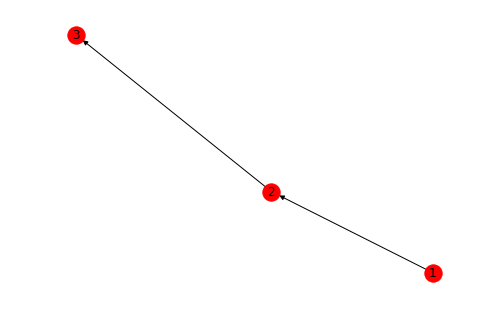

In [11]:
nx.draw(
    lotka_graph,
    with_labels=True
)

In [12]:
lotka_graph.edges()

OutEdgeView([(1, 2), (2, 3)])

### Complex-Stoichiometric Matrix

In [20]:
def build_complex_stoichiometric_matrix(complex_dict, in_graph):
    """FIX ME.
    """
    # Create a list to store the output matrix.
    output = list()
    
    # Create a set, which will contain all the unique compounds.
    # chain.from_iterable unpacks, or flattens, nested lists.
    species = sorted(set(itertools.chain.from_iterable(complex_dict.values())))

    # Iterate through the edges.
    for edge in in_graph.edges():
        
        # Unpack the nodes in this edge.
        node_a, node_b = edge
        
        # Get the complex sets by using node indexes as keys.
        stoich_list = list()
        stoich_list.extend(complex_dict[node_a])
        stoich_list.extend(complex_dict[node_b])
        
        # Create a counter to count the occurences of species
        # within each complex.
        count = collections.Counter(stoich_list)
        
        # Create the stoichiometry row for this complex, and append it
        # to the output list.
        row = [count[s] for s in species]
        output.append(row)

    return np.matrix(output)

In [21]:
complex_stoich_matrix = Z = build_complex_stoichiometric_matrix(complexes, lotka_graph)
complex_stoich_matrix

matrix([[1, 3, 0],
        [0, 2, 1]])

In [22]:
complex_stoich_matrix[0, 0] = 0
complex_stoich_matrix

matrix([[0, 3, 0],
        [0, 2, 1]])

In [23]:
incidence_matrix = B = scipy.sparse.csr_matrix.todense(
    nx.incidence_matrix(  # Assigns each row to a node and each column to an edge.
        lotka_graph, 
        oriented=True,  # Enable +1 or -1 based on edge direction.
        nodelist=sorted(complexes.keys())
    ))
incidence_matrix

matrix([[-1.,  0.],
        [ 1., -1.],
        [ 0.,  1.]])

In [35]:
stoich_matrix = S = Z * B
stoich_matrix

matrix([[ 3., -3.],
        [ 2., -1.]])

### Define Rate Constants

These are arbitrary constants, use whatever coefficient of time desired.

In [29]:
species = x = np.matrix([5000, 3000, 1])
x

matrix([[5000, 3000,    1]])

### Mass Action Kinetics

*Modeling the relation between the reaction rates and species concentrations.*

---

In [51]:
rates = nx.get_edge_attributes(lotka_graph, 'rate')
rates[(1,2)]

5.0

In [52]:
S

matrix([[ 3., -3.],
        [ 2., -1.]])

In [55]:
for idx, j in enumerate(rates.values()):
    
    print(j)
    
    print(Z[idx])
    break

5.0
[[0 3 0]]


$$
v_j(x) = k_j e^{Z^{T}_{S_j} ln(x)}
$$

Where:

+ $v$ : a vector of reaction rates.
+ $x$ : denotes the species concentration vector.
+ $j$ : denotes the j-th reaction.
+ $Z$ : the complex-stoichiometric matrix.
+ $S$ : Stoichiometric matrix.
+ $Z_{S_j}$ : A column of the complex-stoichiometric matrix corresponding to the substrate complex j.
+ $T$ : Denotes the transpose of this matrix.

In [36]:
Z

matrix([[0, 3, 0],
        [0, 2, 1]])

In [50]:
for idx, rate in enumerate(rates.values()):
#     print(rate)
    
    print(Z[idx].T)

    print(np.log(x))
    
    print(Z[idx].T * np.log(x))
    
    print(np.exp(Z[idx].T * np.log(x)))
    
    break
#     print(np.exp(Z[idx].T * np.log(x)))

[[0]
 [3]
 [0]]
[[8.51719319 8.00636757 0.        ]]
[[ 0.          0.          0.        ]
 [25.55157957 24.0191027   0.        ]
 [ 0.          0.          0.        ]]
[[1.00e+00 1.00e+00 1.00e+00]
 [1.25e+11 2.70e+10 1.00e+00]
 [1.00e+00 1.00e+00 1.00e+00]]


In [ ]:
def gillespie_simulaste():
    
    # Calculate the mass-action.
    
    # Calculate the sum of the mass-action.
    
    # Create two random numbers.
    
    # Calculate tau.
    
    # Calculate mu.
    
    

#### References

1. https://arxiv.org/pdf/1211.6643.pdf
2. http://www-users.math.umn.edu/~othmer/graphrt.pdf